In [1]:
import os, json, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path, PureWindowsPath # for Unix compatibility
from pose_models_2d.lib.models.cnn_model import CNNmodel

data_path = os.path.join(os.environ["DATAPATH"], "open", "tactile-servoing-2d-dobot")

In [2]:
# User-defined paths
home_dir = os.path.join("digitac", "model_edge2d")
train_dir =  os.path.join(home_dir, "train") 
valid_dir =  os.path.join(home_dir, "test") 
model_dir =  os.path.join(train_dir, "train2d_cnn")

# Open saved meta dictionaries
with open(os.path.join(data_path, train_dir, "meta.json"), 'r') as f: 
    train_meta = json.load(f)           
with open(os.path.join(data_path, valid_dir, "meta.json"), 'r') as f: 
    valid_meta = json.load(f)    

# Make the new meta dictionary
meta = {**train_meta, 
    # ~~~~~~~~~ Paths ~~~~~~~~~#
    "meta_file": os.path.join(model_dir, "meta.json"),
    "model_file": os.path.join(model_dir, "model.h5"),
    "train_image_dir": train_meta["image_dir"],
    "valid_image_dir": valid_meta["image_dir"],
    "train_df_file": train_meta["target_df_file"],
    "valid_df_file": valid_meta["target_df_file"],
    # ~~~~~~~~~ Model parameters ~~~~~~~~~#
    "num_conv_layers": 5,                                                                   
    "num_conv_filters": 256,                                                                
    "num_dense_layers": 1,                                                                  
    "num_dense_units": 64,  
    "activation": 'elu',                                                         
    "dropout": 0.06,                                                         
    "kernel_l1": 0.0006,                                                       
    "kernel_l2": 0.001,                                                        
    "batch_size": 16, 
    "epochs": 100,
    "patience": 10,
    "lr": 1e-4,
    "decay": 1e-6,
    "target_names": ["pose_2", "pose_6"], 
    # ~~~~~~~~~ Camera settings ~~~~~~~~~#
    # "size": [128, 128], # TacTip
    "size": [160, 120], # DigiTac/Digit
    # ~~~~~~~~~ Comments ~~~~~~~~~#
    "comments": "training 2d cnn model"
    }

In [3]:
# Save dictionary to file
os.makedirs(os.path.join(data_path, model_dir), exist_ok=True)
with open(os.path.join(data_path, meta["meta_file"]), 'w') as f:
    json.dump(meta, f)

# Absolute posix paths
for key in [k for k in meta.keys() if "file" in k or "dir" in k]:
    meta[key] = os.path.join(data_path, meta[key])
    meta[key] = Path(PureWindowsPath(meta[key])).as_posix() # for Unix

In [4]:
def plot_history(history_df):
    plt.rcParams.update({"font.size": 18})
    fig, ax = plt.subplots(ncols=1, figsize=(7, 7))
    history_df.plot(ax=ax, y="loss", label="Training loss")
    history_df.plot(ax=ax, y="val_loss", label="Validation loss")
    ax.set(xlabel="epochs", ylabel="loss"); ax.legend()
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    fig.suptitle(f"Training loss: {min(history_df.loss):.2f} Validation loss: {min(history_df.val_loss):.2f}")    
    return fig

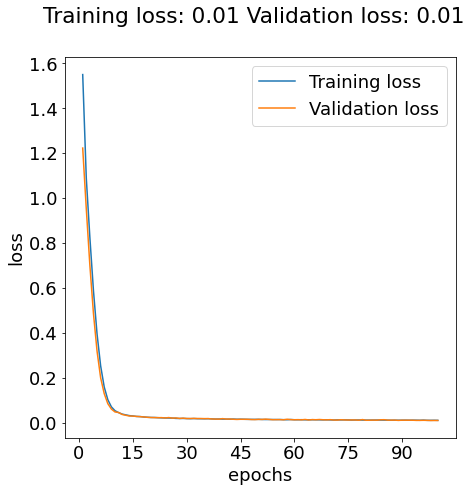

In [6]:
cnn = CNNmodel()
cnn.build_model(**meta)
history = cnn.fit_model(**meta, verbose=1)
    
# Save and plot training history 
history_df = pd.DataFrame(history)
history_df.index += 1 
history_df.to_csv(os.path.join(data_path, model_dir, "history.csv"), index=False)
fig = plot_history(history_df)   
fig.savefig(os.path.join(data_path, model_dir, "history.png"), bbox_inches="tight", pad_inches=0)